In [2]:
from rbm_test import fasta_read, get_checkpoint, get_beta_and_W, all_weights, RBM
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import subprocess as sp
import matplotlib.image as mpimg

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/pig_trained_rbms/"
rounds = ["b3", "n1", "np1", "np2", "np3"]
c1_rounds = [x+"_c1" for x in rounds]
c2_rounds = [x+"_c2" for x in rounds]

In [1]:
# Methods for generating plots etc.
def assign(x):
    if x < 2:
        return "Low"
    elif x < 10:
        return "Mid"
    else:
        return "High"


# Helper Functions for loading data and loading RBMs not in our current directory
def fetch_data(fasta_names, dir="", counts=False):
    for xid, x in enumerate(fasta_names):
        seqs, counts = fasta_read(dir + "/" + x + ".fasta", drop_duplicates=True, seq_read_counts=True)
        round_label = [x for i in range(len(seqs))]
        assignment = [assign(i) for i in counts]
        if xid == 0:
            data_df = pd.DataFrame({"sequence": seqs, "count": counts, "round": round_label, "assignment": assignment})
        else:
            data_df = pd.concat([data_df, pd.DataFrame({"sequence": seqs, "count": counts, "round": round_label, "assignment": assignment})])

    return data_df


def get_checkpoint_path(round, version=None):
    ndir = mdir + round + "/"
    if version:
        version_dir = ndir + f"version_{version}/"
    else:   # Get Most recent i.e. highest version number
        v_dirs = glob(ndir + "/*/", recursive=True)
        versions = [int(x[:-1].rsplit("_")[-1]) for x in v_dirs]  # extracted version numbers

        maxv = max(versions)  # get highest version number
        indexofinterest = versions.index(maxv)  # Get index of the highest version
        version_dir = v_dirs[indexofinterest]  # Access directory path of the highest version

    y = glob(version_dir + "checkpoints/*.ckpt", recursive=False)[0]
    return y, version_dir


# Returns dictionary of arrays of likelihoods
def generate_likelihoods(rounds, RBM, all_data):
    likelihoods = {}
    for x in rounds:
        seqs, likeli = RBM.predict(all_data[all_data["round"] == x])
        likelihoods[x] = likeli
    return likelihoods


# Plot Likelihoods as kde curves with each round in a new row
def plot_likelihoods(likeli, title, xaxislabel, order, labels, colors):
    plot_num = len(likeli.keys())
    fig, axs = plt.subplots(plot_num, 1, sharex=True, sharey=False)
    for xid, x in enumerate(order):
        y = sns.kdeplot(likeli[x], shade=False, alpha=0.5, color=colors[xid], ax=axs[xid], label=labels[xid])
        if xid == len(order) - 1:
            y.set(xlabel=xaxislabel)
        axs[xid].legend()
    fig.suptitle(title)
    plt.show()


## Distribution of Counts inside each experimental dataset
def count_dist(data_w_counts, title):
    sns.histplot(data_w_counts, x="round", hue="assignment", multiple="stack", palette="rocket")
    plt.suptitle(title)
    plt.show()


# Likelihoods must be performed on all the same sequences for both rounds
def compare_likelihood_correlation(likeli1, likeli2, title, rounds):
    fig, axs = plt.subplots(1, 1)
    axs.scatter(likeli1, likeli2, cmap="plasma", alpha=0.75, marker=".")
    axs.set(xlabel=f"Log-Likelihood {rounds[1]}", ylabel=f"Log-Likelihood {rounds[0]}")
    fig.suptitle(title)
    plt.show()


# Return dataframe of specific round with entries with likelihood < lmax and > lmin
def data_subset(data_df, likelihood_dict, target, lmin, lmax):
    tdf = data_df[data_df["round"] == target]
    all_seqs = tdf.sequence.tolist()
    all_counts = tdf.count.tolist()
    likelihood = likelihood_dict[target]
    seqs, counts, ls = zip(*[(all_seqs[xid], all_counts[xid], x) for xid, x in enumerate(likelihood) if lmin < x < lmax])
    final = pd.Dataframe({"sequence": seqs, "count": counts, "likelihood": ls})
    return final


def seq_logo(dataframe, output_file, weight=False, outdir=""):
    out = outdir + output_file
    df = dataframe[["sequence", "count"]]
    df.to_csv('tmp.csv', sep='\t', index=False, header=False)
    if weight:
        sp.check_call(f"/home/jonah/kpLogo/bin/kpLogo tmp.csv -simple -o {out} -alphabet ACDEFGHIKLMNPQRSTVWY- -fontsize 20 -seq 1 -weight 2", shell=True)
    else:
        sp.check_call(f"/home/jonah/kpLogo/bin/kpLogo tmp.csv -simple -o {out} -alphabet ACDEFGHIKLMNPQRSTVWY- -fontsize 20 -seq 1", shell=True)
    sp.check_call("rm tmp.csv", shell=True)


In [4]:
# Stores all data in a dictionary ("data")
data_c1 = fetch_data(c1_rounds, dir="../pig_tissue", counts=True)

In [5]:
# generate weights in respective
for rid, round in enumerate(c1_rounds):
    # if rid > 0:
    #     break
    checkp, version_dir = get_checkpoint_path(round)
    tmp = RBM.load_from_checkpoint(checkp)
    all_weights(tmp, version_dir +round+"_weights", 5, 1, 6, 2, "protein")

/home/jonah/PycharmProjects/phage_display_ML/rbm_torch/rbm_utils.py:297: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

In [5]:
# Generate Sequence Logo for Each round
for r in c1_rounds:
    seq_logo(data_c1[data_c1["round"] == r], f"{r}_seqlogo", weight=False, outdir="../pig_tissue/seqlogos/")
    seq_logo(data_c1[data_c1["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="../pig_tissue/seqlogos/")

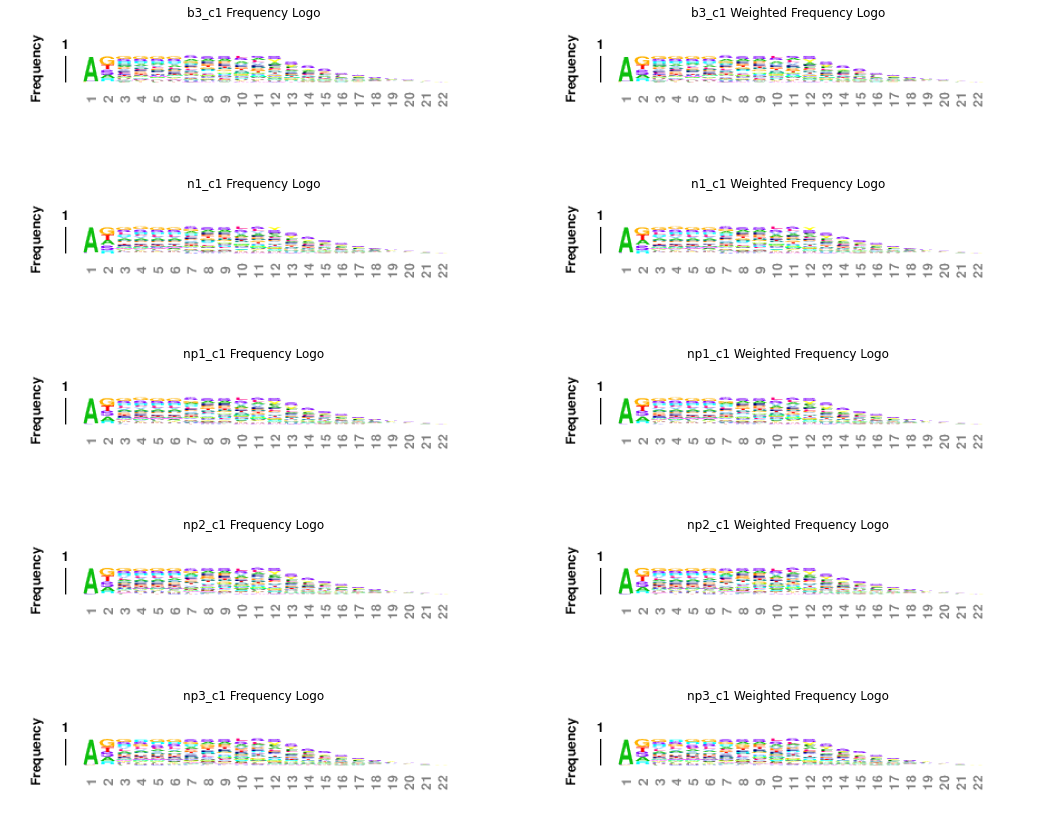

In [18]:
# Seq Logo showing Frequency of Each Amino Acid at each position

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(15, 12)
seqdir = "../pig_tissue/seqlogos/"
plt.tight_layout()
for rid, r in enumerate(c1_rounds):
    img1 = mpimg.imread(f"{seqdir}{r}_seqlogo.freq.png")
    img2 = mpimg.imread(f"{seqdir}{r}_w_seqlogo.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

# plt.axis('off')
plt.show()

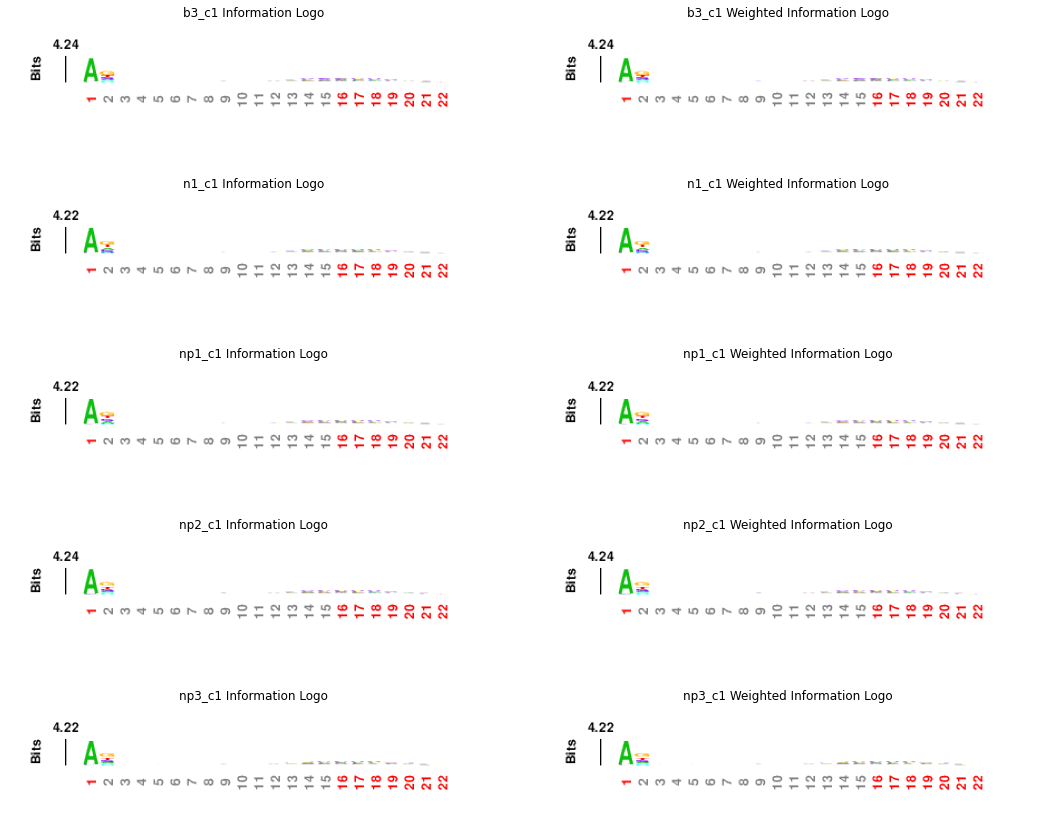

In [20]:
# Seq Logo showing Information of Each Amino Acid at each position

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(15, 12)
seqdir = "../pig_tissue/seqlogos/"
plt.tight_layout()
for rid, r in enumerate(c1_rounds):
    img1 = mpimg.imread(f"{seqdir}{r}_seqlogo.info.png")
    img2 = mpimg.imread(f"{seqdir}{r}_w_seqlogo.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Information Logo")
    axs[rid][1].set_title(f"{r} Weighted Information Logo")

# plt.axis('off')
plt.show()

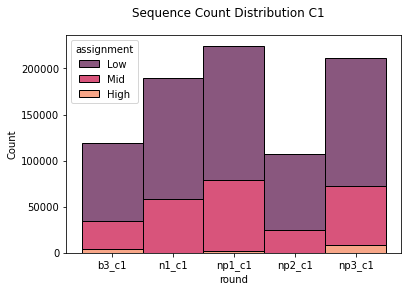

In [58]:
count_dist(data_c1, "Unique Sequence Count Distribution C1")
# Low count == 1, Med count < 10, High count >= 10

In [6]:
# calculate likelihoods from last round rbm only
checkp, v_dir = get_checkpoint_path("np3_c1")
np3_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
np3_likeli = generate_likelihoods(c1_rounds, np3_rbm, data_c1)

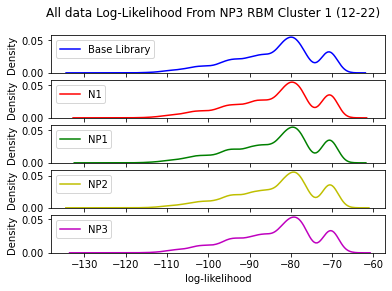

In [7]:
# Plot Likelihoods of Each batch of Data
np3_title = "All data Log-Likelihood From NP3 RBM Cluster 1 (12-22)"
np3_xaxis = "log-likelihood"
np3_order = ["b3_c1", "n1_c1", "np1_c1", "np2_c1", "np3_c1"]
np3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
np3_colors = ["b", "r", "g", "y", "m"]
      
# Should be Enough for most SELEX Experiments
supported_colors =["b", "r", "g", "y", "m", "c", "w", "bl", "k", "c", "DarkKhaki", "DarkOrchid"]
    
plot_likelihoods(np3_likeli, np3_title, np3_xaxis, np3_order, np3_labels, np3_colors)

In [8]:
# calculate likelihoods from last round rbm only
checkp, v_dir = get_checkpoint_path("b3_c1")
b3_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
b3_likeli = generate_likelihoods(c1_rounds, b3_rbm, data_c1)

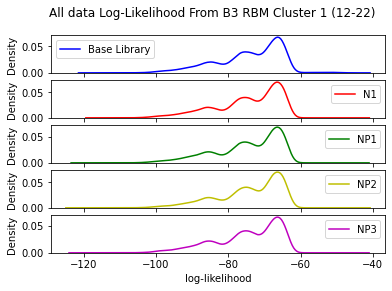

In [9]:
# assign likelihoods in new pd dataframe
b3_title = "All data Log-Likelihood From B3 RBM Cluster 1 (12-22)"
b3_xaxis = "log-likelihood"
b3_order = ["b3_c1", "n1_c1", "np1_c1", "np2_c1", "np3_c1"]
b3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
b3_colors = ["b", "r", "g", "y", "m"]

# Plot Likelihood Distributions
plot_likelihoods(b3_likeli, b3_title, b3_xaxis, b3_order, b3_labels, b3_colors)

In [25]:
# find in common sequences
common = data["b3_c1"].merge(data["np3_c1"], on=['sequence'])
print("Common Sequences b3 & np3", common.shape[0])
common = data["b3_c1"].merge(data["np2_c1"], on=['sequence'])
print("Common Sequences b3 & np2", common.shape[0])
common = data["b3_c1"].merge(data["np1_c1"], on=['sequence'])
print("Common Sequences b3 & np1", common.shape[0])
common = data["b3_c1"].merge(data["n1_c1"], on=['sequence'])
print("Common Sequences b3 & n1", common.shape[0])

# All together
common = data["b3_c1"].merge(data["np3_c1"], on=['sequence'])
common1 = common.merge(data["np2_c1"])
common2 = common1.merge(data["np1_c1"])
common3 = common2.merge(data["n1_c1"])
common4 = data["np1_c1"].merge(data["np2_c1"].merge(data["np3_c1"]))
common5 = common4.merge(data["n1_c1"])
print("Common Sequences b3 & np3", common.shape[0])
print("Common Sequences b3 & np3 & np2", common1.shape[0])
print("Common Sequences b3 & np3 & np2 & np1", common2.shape[0])
print("Common Sequences b3 & np3 & np2 & np1 & n1", common3.shape[0])
print("Common Sequences np3 & np2 & np1 & n1", common5.shape[0])
print("Common Sequences np3 & np2 & np1", common4.shape[0])

Common Sequences b3 & np3 22794
Common Sequences b3 & np2 15037
Common Sequences b3 & np1 26164
Common Sequences b3 & n1 22417
Common Sequences b3 & np3 22794
Common Sequences b3 & np3 & np2 9895
Common Sequences b3 & np3 & np2 & np1 7376
Common Sequences b3 & np3 & np2 & np1 & n1 4443
Common Sequences np3 & np2 & np1 & n1 9894
Common Sequences np3 & np2 & np1 21806


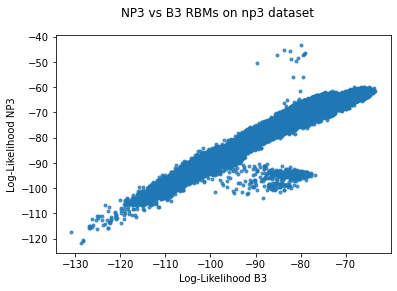

In [10]:
compare_likelihood_correlation(np3_likeli["np3_c1"], b3_likeli["np3_c1"], "NP3 vs B3 RBMs on np3 dataset", ["NP3", "B3"])

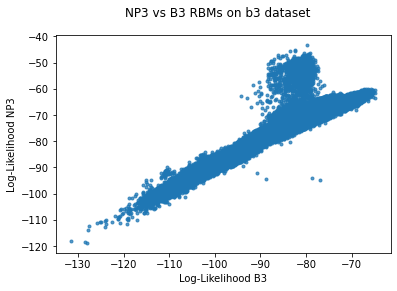

In [11]:
compare_likelihood_correlation(np3_likeli["b3_c1"], b3_likeli["b3_c1"], "NP3 vs B3 RBMs on b3 dataset", ["NP3", "B3"])

## Weighted RBMS

In [13]:
# calculate likelihoods from last round rbm only
checkp, v_dir = get_checkpoint_path("b3_c1_w")
b3_rbm_w = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
b3_likeli_w = generate_likelihoods(c1_rounds, b3_rbm_w, data_c1)

# calculate likelihoods from last round rbm only
checkp, v_dir = get_checkpoint_path("np3_c1_w")
np3_rbm_w = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
np3_likeli_w = generate_likelihoods(c1_rounds, np3_rbm_w, data_c1)

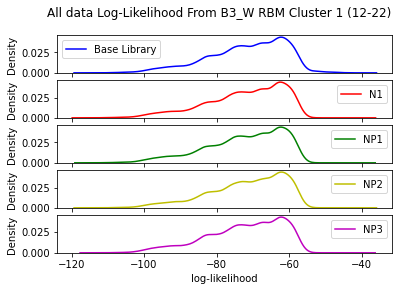

In [14]:
# assign likelihoods in new pd dataframe
b3_title = "All data Log-Likelihood From B3_W RBM Cluster 1 (12-22)"
b3_xaxis = "log-likelihood"
b3_order = ["b3_c1", "n1_c1", "np1_c1", "np2_c1", "np3_c1"]
b3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
b3_colors = ["b", "r", "g", "y", "m"]

# Plot Likelihood Distributions
plot_likelihoods(b3_likeli_w, b3_title, b3_xaxis, b3_order, b3_labels, b3_colors)

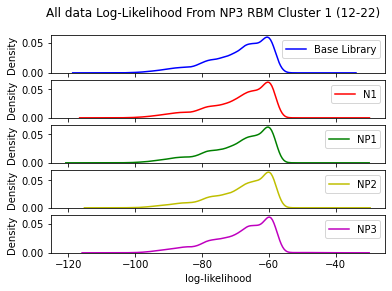

In [15]:
# Plot Likelihoods of Each batch of Data
np3_title = "All data Log-Likelihood From NP3_W RBM Cluster 1 (12-22)"
np3_xaxis = "log-likelihood"
np3_order = ["b3_c1", "n1_c1", "np1_c1", "np2_c1", "np3_c1"]
np3_labels = ["Base Library", "N1", "NP1", "NP2", "NP3"]
np3_colors = ["b", "r", "g", "y", "m"]

# Should be Enough for most SELEX Experiments
supported_colors =["b", "r", "g", "y", "m", "c", "w", "bl", "k", "c", "DarkKhaki", "DarkOrchid"]

plot_likelihoods(np3_likeli_w, np3_title, np3_xaxis, np3_order, np3_labels, np3_colors)

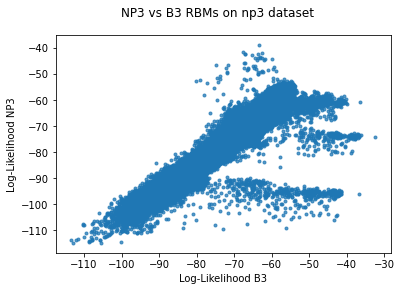

In [16]:
compare_likelihood_correlation(np3_likeli_w["np3_c1"], b3_likeli_w["np3_c1"], "NP3_W vs B3_W RBMs on np3 dataset", ["NP3", "B3"])

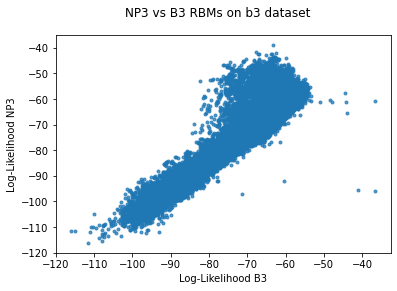

In [17]:
compare_likelihood_correlation(np3_likeli_w["b3_c1"], b3_likeli_w["b3_c1"], "NP3 vs B3 RBMs on b3 dataset", ["NP3", "B3"])